<a href="https://colab.research.google.com/github/srinath2022/physics-based-DL/blob/master/simpleExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Toy Example

We will start off by considering a toy example of tossing a coin and eventually add air resistance etc. Let us begin by writing down the velocity and displacement equations of a point mass object thrown vertically above the ground with an initial velocity $u_0$.   

Under the effect of gravity, the velocity of the object at any time instant from start($t=0$) is given by   

$ v_t = u_0 + gt $   

where $g$ represents acceleration due to gravity $\sim 10 \frac{m}{s^2}$ 

Also, the displacement covered by the point mass is given by

$ s_t = u_0t + \frac{1}{2}gt^2 $


## The Simulation

We first show a simulation of this using pure physics equations. For simplicity let us target the velocity first, as it is linear with time.

In [ ]:
# Import necessary modules
import matplotlib.pyplot as plt

In [ ]:
# Acceleration due to gravity
g = -10 # m/s^2

In [ ]:
# Velocity of the particle at time step T. Initial velocity of the particle is u.
def velocity_t(u, t):
  return u + g*t

In [ ]:
# Displacement by the particle
def displacement_t(u, t):
  return u*t+(1/2)*g*t*t

In [ ]:
def simulate_flight(u_initial):
  T =  -2*u_initial/(g) # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = velocity_t(u_initial, t)
    s_t = displacement_t(u_initial, t)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

In [ ]:
# Plot the simulation
def plot_simulation(times, velocities, displacements):
  plt.plot(times, velocities)
  plt.plot(times, displacements)
  plt.ylabel('velocity')
  plt.xlabel('time')
  plt.show()

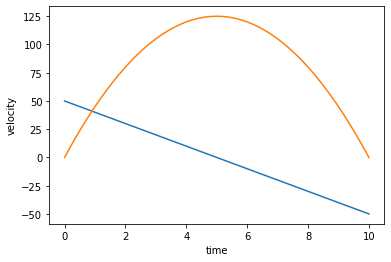

In [ ]:
# Testing the simulation
times, velocities, displacements = simulate_flight(50)
plot_simulation(times, velocities, displacements)

## The Data
Now that we have a physics simulation, let us run few simulations and collect the data. i,e we input few random initial velocities, times and get the corresponding velocities during the flight.

For this specific task, let us keep the initial velocities between $0$ to $100$ and time step range betwen $0$ to time of flight $T.$ 

$$u_0 \in (0, 100)$$

The collected data would look like this, $X, Y$ where
$X = (u, t), Y = (v)$   
$u, t$ represent initial velocity and time step, where as $v$ represents corresponding velocity.

In [ ]:
import numpy as np

In [ ]:
# Min and Max of initial velocity (in m/s)
U0_MIN = 0
U0_MAX = 100

def create_data(N_DATA_SAMPLES, D_TYPE, U0_MIN=U0_MIN, U0_MAX=U0_MAX):
  if D_TYPE not in ['VELOCITY', 'DISPLACEMENT', 'VELOCITY_DISPLACEMENT']:
    return
  data = []
  for i in range(N_DATA_SAMPLES):
    u0 = U0_MIN + np.random.rand(1)*(U0_MAX - U0_MIN)
    T   = (-2*u0)/g # time of flight
    t   = np.random.rand(1)*T
    v_t = velocity_t(u0, t)
    s_t = displacement_t(u0, t)

    # create a data point
    Y = None
    if D_TYPE=='VELOCITY':
      Y = np.array([v_t])
    elif D_TYPE=='DISPLACEMENT':
      Y = np.array([s_t])
    elif D_TYPE=='VELOCITY_DISPLACEMENT':
      Y = np.array([v_t, s_t])
    else:
      return

    datapoint = (np.array([u0, t]), Y)
    data.append(datapoint)

  print("Dataset created!!")
  print("Dataset size", len(data))
  return data

## Only Deep Learing based approach

We have collectd some data, Let us use a simple neural network to train upon that data to predict the velocity $v_t$ at a time $t$, given an initial veclocity $u_0$.

We will be experimenting with various models, train them and try the inference.

In [ ]:
# Necessary modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")
print(device)

cuda:0


In [ ]:
def compare_plot(times, actual, predicted, D_TYPE):
  plt.figure()
  plt.plot(times, actual, 'g')
  plt.plot(times, predicted, 'b')
  plt.ylabel(D_TYPE)
  plt.xlabel('time')
  plt.show()

In [ ]:
# Plotting the train loss curve
def loss_plot(epochs, losses):
  plt.figure()
  plt.plot(epochs, losses, 'r')
  plt.ylabel("Loss")
  plt.xlabel('Epoch')
  plt.show()

### Dataset
Let us define the appropriate dataset.

In [ ]:
# Dataset
class PhysicsData(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    return self.data[index]

### Inference
Let us first create and keep the inference part ready, so that we could infer and check the infered simulation on any trained network. This will make our life easier to test with various models we might try out until a good fitting one is found.

This is to infer the output for a single input, say at time $t$, for given initial velocity $u_0$

In [ ]:
# Infer the output for a single input (at time t, given initial velocity) on the trained network.
# Assuming model is already transferred to the device.
def single_inference(D_TYPE, model, u0, t):
  input   = torch.tensor([[u0, t]])
  input   = input.unsqueeze(0)
  input   = input.to(device)
  output  = model(input.float())
  output  = output.cpu().data.numpy()

  if D_TYPE=='VELOCITY':
    return output[0][0][0], 0
  elif D_TYPE=='DISPLACEMENT':
    return 0, output[0][0][0]
  elif D_TYPE=='VELOCITY_DISPLACEMENT':
    return output[0][0][0], output[0][0][1]
  else:
    return

Now, let us use the single inference to infer the whole simulation, given the initial velocity $u_0$

In [ ]:
def simulation_inference(D_TYPE, model, u0):
  model = model.to(device)
  T = (-2*u0)/g # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = None
    s_t = None
    v_t, s_t = single_inference(D_TYPE, model, u0, t)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

### Training
We write the appropriate training module to train any generic model with specified parameters

In [ ]:
# Training
def train(model, train_dataloader, optimizer, criterion, epochs, verbose=False):
  model = model.to(device)
  model.train()

  all_epochs = []
  all_losses = []

  epoch_loss = 0.0
  for epoch in range(epochs):
    epoch_loss = 0.0
    for i, batch in enumerate(train_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      optimizer.zero_grad()
      loss = criterion(Y_predicted, Y.float(), X.float())
      epoch_loss = epoch_loss+loss.item()
      loss.backward()
      optimizer.step()

    if verbose:
      print(f"epoch : {epoch+1}, loss : {epoch_loss/len(train_dataloader):.5f}")
    else:
      if epoch%10 == 0:
        print(f"epoch : {epoch}, loss : {epoch_loss/len(train_dataloader):.5f}")

    all_epochs.append(epoch+1)
    all_losses.append(epoch_loss/len(train_dataloader))
  
  print("Done Training!")
  print(f"epoch : {epochs}, loss : {epoch_loss/len(train_dataloader):.5f}")
  return model, all_losses, all_epochs


In [ ]:
# Testing
def test(model, test_dataloader, criterion):
  model = model.to(device)
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      loss = criterion(Y_predicted, Y.float(), X.float())
      total_loss = total_loss+loss.item()

  avarage_loss = total_loss/len(test_dataloader)
  print(f"Average loss : {avarage_loss:.5f}")
  return avarage_loss

### Models
Define various models.

In [ ]:
# A Simple model for predicting only Velocity
class VelocityNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=5)
    self.nn2 = nn.Linear(in_features=5, out_features=5)
    self.nn3 = nn.Linear(in_features=5, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

In [ ]:
# Simple model for predicting Displacement
# Similar to the Velocity Model, but has more neurons.
class DisplacementNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=16)
    self.nn3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

In [ ]:
# Simple model for predicting both Velocity and Displacement
class NewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.tanh(x)
    x = self.nn2(x)
    x = self.tanh(x)
    x = self.nn3(x)
    return x

### Experiments
We run experiments on various models, keep track of hyperparameters, run inference and try to find the best model for our goal.

Let us define custom Loss class to handle various losses we might design later

In [ ]:
# Define custom loss
class CustomMSELoss(nn.Module):
  def __init__(self):
    super(CustomMSELoss, self).__init__()
    self.mseLoss = nn.MSELoss()

  def forward(self, Y_predicted, Y_actual, X):
    loss = self.mseLoss(Y_predicted, Y_actual)
    return loss

#### Predicting only Velocity
Let us use the simplest model, VelocityNewtonNet to predict velocity.
We will create a dataset of 10000 entries for this.

In [ ]:
N_DATA_SAMPLES = 10000
simulation_data_velocity = create_data(N_DATA_SAMPLES, 'VELOCITY')
train_dataset_velocity_10000 = PhysicsData(simulation_data_velocity[:int(N_DATA_SAMPLES*0.8)])
test_dataset_velocity_10000 = PhysicsData(simulation_data_velocity[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


Train the network on the velocity dataset.

In [ ]:
BATCH_SIZE          = 8
model_v             = VelocityNewtonNet()
train_dataloader_v  = DataLoader(train_dataset_velocity_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v         = optim.SGD(model_v.parameters(), lr= 0.000001, momentum=0.9)
optimizer_v         = optim.Adam(model_v.parameters(), lr = 0.005)
criterion           = CustomMSELoss()
epochs              = 30

epoch : 0, loss : 307.62821
epoch : 10, loss : 0.03862
epoch : 20, loss : 0.03459
Done Training!
epoch : 30, loss : 0.09893


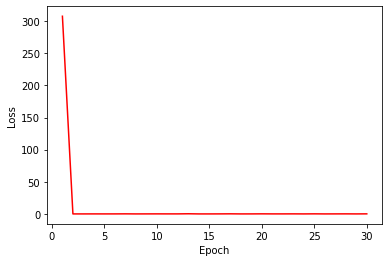

In [ ]:
model_v, t_loss, t_epochs = train(model_v, train_dataloader_v, optimizer_v, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

Calculate the test loss and run few inferences to visualise the prediction.

In [ ]:
# Test loss
test_dataloader_v = DataLoader(test_dataset_velocity_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v, test_dataloader_v, criterion)

Average loss : 0.00000


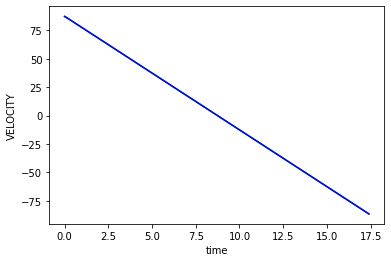

In [ ]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p = simulation_inference('VELOCITY', model_v, U_INITIAL)
times, velocities, displacements = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')

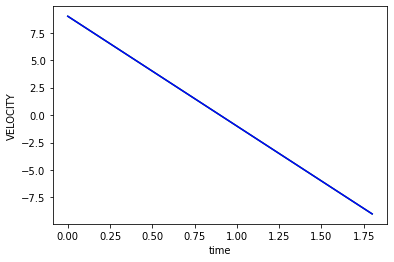

In [ ]:
# Run simulation and compare, a case where it doesn't match exactly
U_INITIAL = 9
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY', model_v, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')

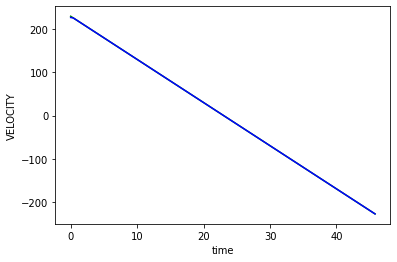

In [ ]:
# Run simulation and compare, a case where u0 is out of dataset domain
U_INITIAL = 230
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY', model_v, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')

#### Predicting only Displacement

In [ ]:
# Let us create a similar dataset for displacement task
N_DATA_SAMPLES                    = 10000
simulation_data_displacement      = create_data(N_DATA_SAMPLES, 'DISPLACEMENT')
train_dataset_displacement_10000  = PhysicsData(simulation_data_displacement [:int(N_DATA_SAMPLES*0.8)])
test_dataset_displacement_10000   = PhysicsData(simulation_data_displacement [int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


In [ ]:
BATCH_SIZE          = 32
model_s             = DisplacementNewtonNet()
train_dataloader_s  = DataLoader(train_dataset_displacement_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_s         = optim.SGD(model_s.parameters(), lr= 0.000001, momentum=0.9)
optimizer_s         = optim.Adam(model_s.parameters(), lr = 0.005)
criterion           = CustomMSELoss()
epochs              = 120

epoch : 0, loss : 6200.14752
epoch : 10, loss : 164.72308
epoch : 20, loss : 65.27198
epoch : 30, loss : 46.12351
epoch : 40, loss : 44.02711
epoch : 50, loss : 51.15585
epoch : 60, loss : 42.17104
epoch : 70, loss : 51.49831
epoch : 80, loss : 45.96331
epoch : 90, loss : 49.81235
epoch : 100, loss : 44.68011
epoch : 110, loss : 40.16047
Done Training!
epoch : 120, loss : 38.49970


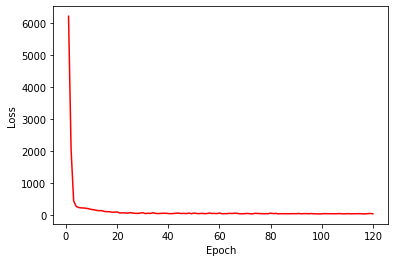

In [ ]:
model_s, t_loss, t_epochs = train(model_s, train_dataloader_s, optimizer_s, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

In [ ]:
# Test loss
test_dataloader_s = DataLoader(test_dataset_displacement_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_s, test_dataloader_s, criterion)

Average loss : 120.43340


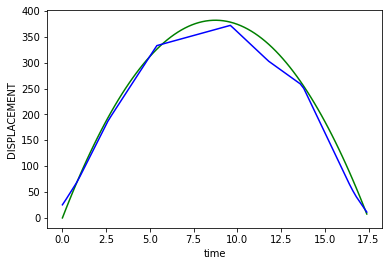

In [ ]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

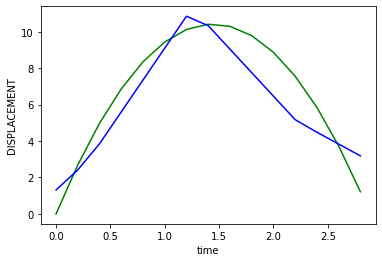

In [ ]:
# Run simulation and compare, a case where u0 is small
U_INITIAL = 14.434
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

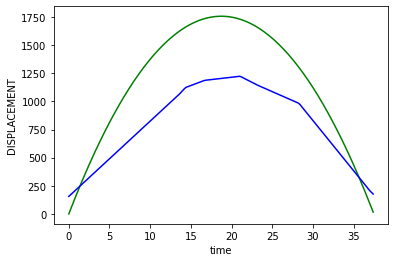

In [ ]:
# Run simulation and compare, a case where u0 is not in dataset domain
U_INITIAL = 187.434
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

#### Predicting both Velocity and Displacement

In [ ]:
# Let us create a similar dataset for velocity, displacement task
N_DATA_SAMPLES                    = 10000
simulation_data_v_s               = create_data(N_DATA_SAMPLES, 'VELOCITY_DISPLACEMENT')
train_dataset_v_s_10000           = PhysicsData(simulation_data_v_s[:int(N_DATA_SAMPLES*0.8)])
test_dataset_v_s_10000            = PhysicsData(simulation_data_v_s[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


In [ ]:
BATCH_SIZE            = 32
model_v_s             = NewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s         = optim.SGD(model_v_s.parameters(), lr=0.000001, momentum=0.9)
optimizer_v_s         = optim.Adam(model_v_s.parameters(), lr = 0.005)
criterion             = CustomMSELoss()
epochs                = 300

epoch : 0, loss : 13788.36319
epoch : 10, loss : 8619.92069
epoch : 20, loss : 5354.62129
epoch : 30, loss : 3226.51490
epoch : 40, loss : 1893.58278
epoch : 50, loss : 1037.77805
epoch : 60, loss : 550.38427
epoch : 70, loss : 301.17806
epoch : 80, loss : 166.55429
epoch : 90, loss : 86.89241
epoch : 100, loss : 65.49167
epoch : 110, loss : 60.23506
epoch : 120, loss : 39.14738
epoch : 130, loss : 43.65067
epoch : 140, loss : 29.90223
epoch : 150, loss : 24.79053
epoch : 160, loss : 50.85841
epoch : 170, loss : 25.95026
epoch : 180, loss : 26.14866
epoch : 190, loss : 17.14645
epoch : 200, loss : 78.49977
epoch : 210, loss : 26.21352
epoch : 220, loss : 22.53973
epoch : 230, loss : 27.93413
epoch : 240, loss : 59.00269
epoch : 250, loss : 14.20621
epoch : 260, loss : 58.41268
epoch : 270, loss : 25.97857
epoch : 280, loss : 31.43557
epoch : 290, loss : 26.79743
Done Training!
epoch : 300, loss : 26.07129


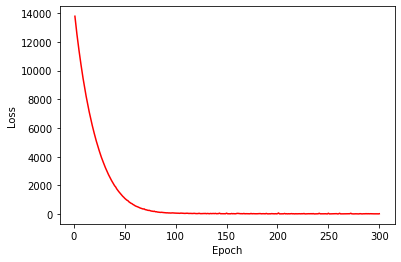

In [ ]:
model_v_s, t_loss, t_epochs = train(model_v_s, train_dataloader_v_s, optimizer_v_s, criterion, epochs)
loss_plot(t_epochs, t_loss)

In [ ]:
# Test loss
test_dataloader_v_s = DataLoader(test_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s, test_dataloader_v_s, criterion)

Average loss : 14.01075


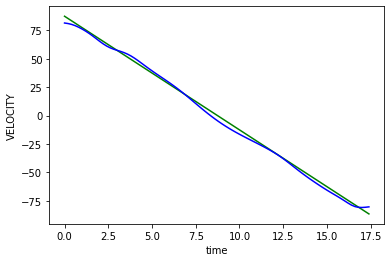

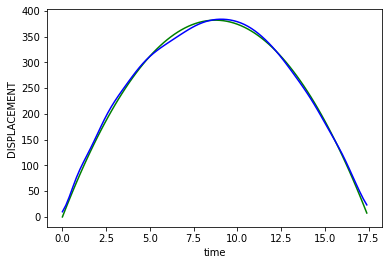

In [ ]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

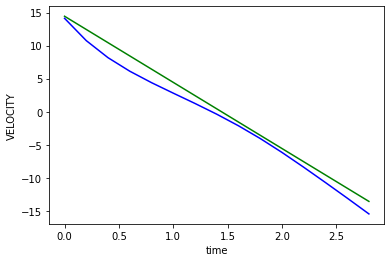

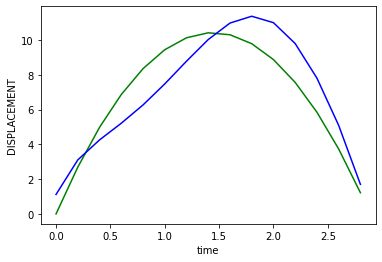

In [ ]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

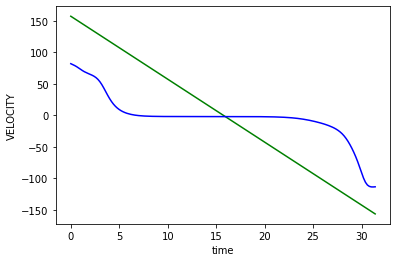

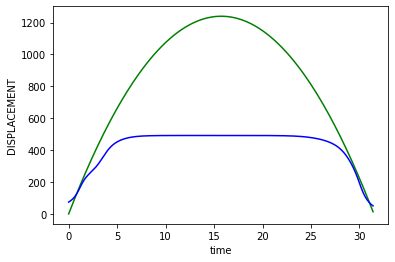

In [ ]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 157.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Using Physics Knowledge for training
As we know some properties of the predicted values from physics, like the velocities over time lie on a line, displacements over time lie on a parabola and also $v_t$, $s_t$ have the following relation   

$v_t^2-u_0^2 = 2*g*s_t$

Let us try to leverage this knowledge and see if it improves our model.

In [ ]:
# Simple model for predicting both Velocity and Displacement
class PhysicsNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.tanh(x)
    x = self.nn2(x)
    x = self.tanh(x)
    x = self.nn3(x)
    return x

#### Designing a Loss function
We are trying to predict two values namely $v_t$ and $s_t$. From our previous experiments, it is evident that prediction of velocity is fairly accurate even for a minimal network, however prediction of displacement is in accurate and kind of overfit. 

##### 1. Physics based loss
Leveraging the relationship between predicted values $v_t$ and $s_t$, let us try experimenting with the following loss purly based on physics.

$L_{physics} = |v_{predicted}^2-u_{initial}^2-2*g*s_{predicted}|$

In [ ]:
# Define new loss
class PhysicsBasedLoss(nn.Module):
  def __init__(self):
    super(PhysicsBasedLoss, self).__init__()

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), 2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    absolute_difference = torch.absolute(difference)
    loss = torch.sum(absolute_difference)
    return loss

In [ ]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE            = 32
model_v_s_phy         = PhysicsNewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_phy     = optim.SGD(model_v_s_phy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_phy     = optim.Adam(model_v_s_phy.parameters(), lr = 0.005)
criterion             = PhysicsBasedLoss()
epochs                = 200

epoch : 0, loss : 104417.28994
epoch : 10, loss : 15785.77572
epoch : 20, loss : 4961.86910
epoch : 30, loss : 3156.93641
epoch : 40, loss : 3073.96180
epoch : 50, loss : 2983.33129
epoch : 60, loss : 3223.69878
epoch : 70, loss : 2836.86715
epoch : 80, loss : 2560.36556
epoch : 90, loss : 2688.78674
epoch : 100, loss : 2423.34095
epoch : 110, loss : 2947.40334
epoch : 120, loss : 2524.28193
epoch : 130, loss : 2239.42811
epoch : 140, loss : 2573.47758
epoch : 150, loss : 2222.22570
epoch : 160, loss : 2336.03731
epoch : 170, loss : 2070.10083
epoch : 180, loss : 2720.93748
epoch : 190, loss : 1949.86706
Done Training!
epoch : 200, loss : 1838.81204


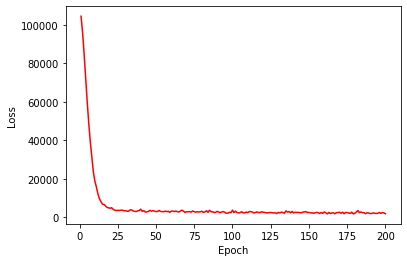

In [ ]:
model_v_s_phy, t_loss, t_epochs = train(model_v_s_phy, train_dataloader_v_s, optimizer_v_s_phy, criterion, epochs)
loss_plot(t_epochs, t_loss)

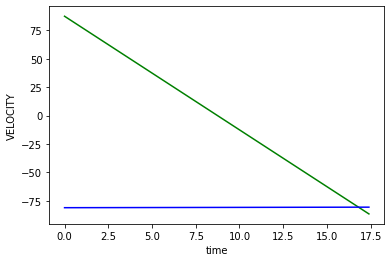

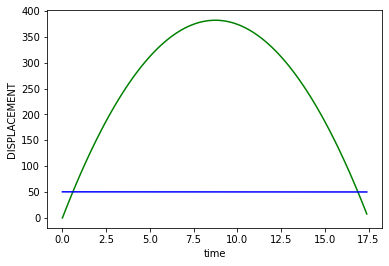

In [ ]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

First of all, the model hasn't converged. However, the predictions make sense as we are not using the time input anywhere in our loss, so predicting a constant number over time is fine. The wonder is, for every $u$, why can't it predict some $v_t, s_t$ such that the physics relation between them hold?. Need to run more experiments on this to come to a conclusive argument.

##### 2. Velocity + Physics based loss
Let us try the folowing loss where we try to make the velocity closer to actual velocity but provide no ground truth information on displacement, rather we make use of the relation between $v_t$, $s_t$ to guide the learning.

$L_{velocity+phy} = |v_{predicted}-v_{actual})|+|v_{predicted}-u_{initial}^2-2*g*s_{predicted}|$

This will go to $0$ only when $v_{predicted} = v_{actual}$ and $v_{predicted}^2-u_{initial}^2 = 2*g*s_{predicted}$, both of which yield correct prediction for $v_t$ and $s_t$

In [ ]:
class VelocityPlusPhysicsBasedLoss(nn.Module):
  def __init__(self):
    super(VelocityPlusPhysicsBasedLoss, self).__init__()

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), 2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    absolute_difference = torch.absolute(difference)

    v_actual = Y_actual[:, :, 0]
    difference_v = torch.subtract(v_predicted, v_actual)
    absolute_difference_v = torch.absolute(difference_v)

    loss = torch.add(torch.sum(absolute_difference_v), torch.sum(absolute_difference))
    return loss

In [ ]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE                  = 32
model_v_s_velocityPhy       = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_velocityPhy   = optim.SGD(model_v_s_velocityPhy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_velocityPhy   = optim.Adam(model_v_s_velocityPhy.parameters(), lr = 0.005)
criterion                   = VelocityPlusPhysicsBasedLoss()
epochs                      = 300

epoch : 0, loss : 105484.54850
epoch : 10, loss : 16053.17813
epoch : 20, loss : 5618.99218
epoch : 30, loss : 6013.10995
epoch : 40, loss : 4270.41867
epoch : 50, loss : 4450.85058
epoch : 60, loss : 4325.11782
epoch : 70, loss : 3996.09760
epoch : 80, loss : 4010.82370
epoch : 90, loss : 4358.62673
epoch : 100, loss : 3755.78164
epoch : 110, loss : 4017.21211
epoch : 120, loss : 3877.85087
epoch : 130, loss : 4282.72836
epoch : 140, loss : 3387.38332
epoch : 150, loss : 3550.85859
epoch : 160, loss : 3354.66161
epoch : 170, loss : 4040.69329
epoch : 180, loss : 3416.25247
epoch : 190, loss : 3395.91051
epoch : 200, loss : 3597.83393
epoch : 210, loss : 4000.71551
epoch : 220, loss : 3506.22736
epoch : 230, loss : 3436.49475
epoch : 240, loss : 3405.35686
epoch : 250, loss : 3458.64732
epoch : 260, loss : 3209.45874
epoch : 270, loss : 2838.97042
epoch : 280, loss : 3427.01412
epoch : 290, loss : 3446.77620
Done Training!
epoch : 300, loss : 3524.48144


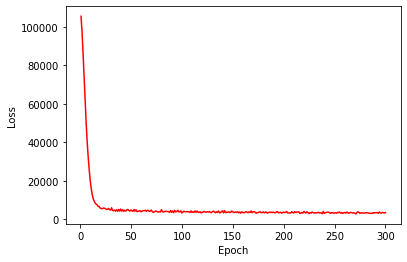

In [ ]:
model_v_s_velocityPhy, t_loss, t_epochs = train(model_v_s_velocityPhy, train_dataloader_v_s, optimizer_v_s_velocityPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

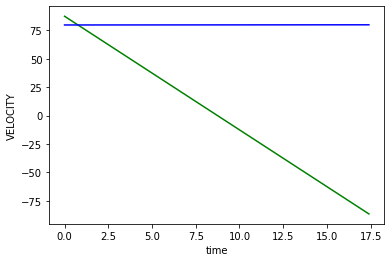

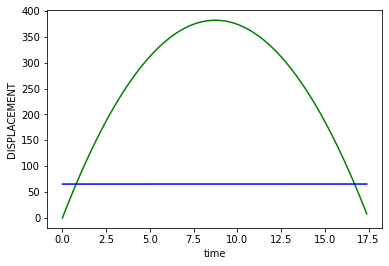

In [ ]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

Not an expected result. Need to analyse the network/loss for implementation erros.

## Summary
### To be completed

| Experiment Description        | Parameters            | Results     | Comments |
| ----------------------        |  ---------            |  ------     |  ------- |
| Only Velocity Prediction      | dataset size : 10000  | ~100% accuracy
|                               |  small NN(2->5->5->1) |
|
|